In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
import zipfile
file=zipfile.ZipFile('../input/homesite-quote-conversion/train.csv.zip','r')
file.extractall()
file.close()

In [3]:
file=zipfile.ZipFile('../input/homesite-quote-conversion/test.csv.zip','r')
file.extractall()
file.close()

In [4]:
df=pd.read_csv('./train.csv')


In [5]:
df.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL


In [6]:
df['Original_Quote_Date']=pd.to_datetime(df['Original_Quote_Date'])
df['weekdays']=df['Original_Quote_Date'].dt.dayofweek

In [7]:
df['month']=df['Original_Quote_Date'].dt.month
df['months_sin']=df['month'].apply(lambda x: np.sin(2*np.pi*((x-1)/11)))
df['months_cos']=df['month'].apply(lambda x: np.cos(2*np.pi*((x-1)/11)))
df['weekdays_sin']=df['weekdays'].apply(lambda x: np.sin(2*np.pi*(x/6)))
df['weekdays_cos']=df['weekdays'].apply(lambda x: np.cos(2*np.pi*(x/6)))

In [8]:
df.drop(['month','weekdays','Original_Quote_Date'],axis=1,inplace=True)

In [9]:
df['Field6'].unique()

array(['B', 'F', 'J', 'E', 'C', 'K', 'A', 'D'], dtype=object)

In [10]:
df['Field6']=df['Field6'].apply(lambda x: x if x not in ['C','A','D'] else 'field6_others')

In [11]:
df.drop(['PersonalField7','PropertyField29','PropertyField6','GeographicField10A',
         ],
        axis=1,inplace=True)
df['PersonalField84'].fillna(value=-1,inplace=True)
df['PropertyField3'].fillna(value='N',inplace=True)
df['PropertyField4'].fillna(value='N',inplace=True)
df['PropertyField32'].fillna(value='Y',inplace=True)
df['PropertyField34'].fillna(value='Y',inplace=True)
df['PropertyField36'].fillna(value='N',inplace=True)
df['PropertyField38'].fillna(value='N',inplace=True)


In [12]:
data=df.drop(['QuoteConversion_Flag','QuoteNumber','months_sin',
 'months_cos',
 'weekdays_sin',
 'weekdays_cos'],axis=1)

In [13]:
from tqdm import tqdm

In [14]:
matrix=data.corr().values

In [15]:
cols1=set()
cols2=set()
for i in tqdm(range(matrix.shape[0])):
    for j in range(matrix.shape[0]):
        if i<j:
            if matrix[i,j]>0.7:
                cols1.add(i)
                cols2.add(j)
cols_of_matrix=list(data.corr().columns)
df.drop([cols_of_matrix[i] for i in list(cols1.intersection(cols2))],axis=1,inplace=True)
data.drop([cols_of_matrix[i] for i in list(cols1.intersection(cols2))],axis=1,inplace=True)
first_drop=[cols_of_matrix[i] for i in list(cols1.intersection(cols2))]
matrix=np.array(data.corr())
cols1=set()
for i in tqdm(range(matrix.shape[0])):
    for j in range(matrix.shape[0]):
        if i<j:
            if matrix[i,j]>0.7:
                cols1.add(i)
cols_of_matrix=list(data.corr().columns)
df.drop([cols_of_matrix[i] for i in list(cols1)],axis=1,inplace=True)
data.drop([cols_of_matrix[i] for i in list(cols1)],axis=1,inplace=True)
second_drop=[cols_of_matrix[i] for i in list(cols1)]

100%|██████████| 167/167 [00:00<00:00, 13487.81it/s]


In [16]:
data.corr().shape

(111, 111)

In [17]:
numeric_columns=list(data.corr().columns)

In [18]:
types=pd.DataFrame(df.dtypes)

In [19]:
import pickle

In [20]:

with open('numeric_columns.pkl','wb') as f:
    pickle.dump(numeric_columns,f)

In [21]:
types[0].unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [22]:
types.reset_index(inplace=True)

In [23]:
types.rename(columns={'index':'columns',0:'dtype'},inplace=True)

In [24]:
types.to_csv('dtypes.csv',index=False)

In [25]:
category_columns=list(types[types['dtype']=='object']['columns'])

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
encoding_dict={}

In [28]:
for i,col in tqdm(enumerate(category_columns)):
  ohe=OneHotEncoder(sparse=False,handle_unknown='ignore')
  ohe.fit(df[[col]])
  encoding_dict[col]={}
  categories=list(df[col].unique())
  encoding_dict[col]['categories']=list(f"{c}_{i}" for c in categories)
  encoding_dict[col]['transformer']=ohe
  temp=pd.DataFrame(data=ohe.transform(df[[col]]),columns=list(f"{c}_{i}" for c in categories))
  df=df.join(temp)
  df.drop(col,axis=1,inplace=True)

26it [00:36,  1.41s/it]


In [29]:
with open('categorical_encoding.pkl','wb') as f:
    pickle.dump(encoding_dict,f)

In [30]:
df.head()

,QuoteNumber,QuoteConversion_Flag,Field7,Field8,CoverageField5B,CoverageField6B,CoverageField11B,SalesField1B,SalesField2B,SalesField3,...,Y_22,N_23,Y_23,N_24,Y_24,_24,CA_25,NJ_25,TX_25,IL_25
0,1,0,23,0.9403,22,23,1,18,8,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2,0,7,1.0006,22,23,9,14,18,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,0,7,1.0006,25,23,6,10,11,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6,0,10,0.9769,22,23,23,19,24,0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,8,0,23,0.9472,22,23,6,6,6,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [31]:
#!pip install optuna
!pip install imblearn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [34]:
from xgboost import XGBClassifier
x=df.drop(['QuoteConversion_Flag','QuoteNumber'],axis=1).values
y=df['QuoteConversion_Flag'].values
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.metrics import roc_auc_score
stf=StratifiedKFold(n_splits=5)
smote=SMOTE(sampling_strategy='minority')
scaler=StandardScaler()
df['kfolds']=-1
for i,(train,test) in enumerate(stf.split(x,y)):
    df.loc[test,'kfolds']=i
train=df[df['kfolds']!=0].drop(['kfolds','QuoteNumber'],axis=1).reset_index(drop=True)
test=df[df['kfolds']==0].drop(['kfolds','QuoteNumber'],axis=1).reset_index(drop=True)
x_train=train.drop('QuoteConversion_Flag',axis=1).values
y_train=train['QuoteConversion_Flag'].values
x_test=test.drop('QuoteConversion_Flag',axis=1).values
y_test=test['QuoteConversion_Flag'].values
x_train,y_train=smote.fit_sample(x_train,y_train)
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)


In [35]:
with open('standard_scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

In [36]:
!pip install optuna
#!pip uninstall lightgbm

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [37]:
#from sklearn.ensemble import RandomForestClassifier

In [38]:
#def objective(trial):
#    n_estimators=trial.suggest_int('n_estimators',100,1000,50)
#    max_depth=trial.suggest_int('max_depth',4,30)
#    min_samples_split=trial.suggest_discrete_uniform('min_samples_split',0.01,0.3,0.01)
#    rfc=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,
#                              n_jobs=-1)
#    rfc.fit(x_train,y_train)
#    predicts=rfc.predict_proba(x_test)
#    predicts=predicts[:,1]
#    score=roc_auc_score(y_test,predicts)
#    return score
#study=optuna.create_study(direction='maximize')
#study.optimize(objective,n_trials=200)

In [39]:
#study.best_value

In [40]:
#study.best_params

In [41]:
#!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

lightgbm

In [42]:
from lightgbm import LGBMClassifier,early_stopping
#def objective(trial):
#    num_leaves=trial.suggest_int('num_leaves',2,50,2)
#    max_depth=trial.suggest_int('max_depth',4,20)
#    subsample=trial.suggest_uniform('subsample',0.6,0.95)
#    colsample_bytree=trial.suggest_uniform('colsample_bytree',0.6,0.95)
#    reg_lambda=trial.suggest_uniform('reg_lambda',1,1000)
#    lgb=LGBMClassifier(device_type='gpu',
#                      num_leaves=num_leaves,
#                      max_depth=max_depth,
#                     subsample=subsample,
#                      colsample_bytree=colsample_bytree,
#                      reg_lambda=reg_lambda,
#                      objective='binary',
#                      n_estimators=100)
#    lgb.fit(x_train,y_train,eval_set=[(x_test,y_test)],
#            eval_metric='auc',verbose=0)
#    predictions=lgb.predict_proba(x_test)
#    predictions=predictions[:,1]
#    score=roc_auc_score(y_test,predictions)
#    return score
#study=optuna.create_study(direction='maximize')
#study.optimize(objective,n_trials=200)

In [43]:
#study.best_params

In [44]:
#study.best_value

In [45]:
import gc

In [46]:
del matrix,types

In [47]:
gc.collect()

100

In [ ]:
colsample_bytree= 0.8046428034931054
max_depth= 16
num_leaves= 50
reg_lambda=  3.4978019215584313
subsample=0.6005334143665317

In [ ]:
lgb=LGBMClassifier(device_type='gpu',
                      num_leaves=num_leaves,
                      max_depth=max_depth,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      reg_lambda=reg_lambda,
                      objective='binary',
                      n_estimators=500,learning_rate=0.05
                      )
final_lgb=LGBMClassifier(device_type='gpu',
                      num_leaves=num_leaves,
                      max_depth=max_depth,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      reg_lambda=reg_lambda,
                      objective='binary',
                      n_estimators=500,learning_rate=0.05
                      )
lgb.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
            eval_metric='auc')
final_lgb.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
            eval_metric='auc',verbose=0)

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fig,ax=plt.subplots(sharey=True)
sn.lineplot(list(range(len(lgb.evals_result_.get('training').get('auc')))),lgb.evals_result_.get('training').get('auc'),color='green',label='training_auc',ax=ax)
sn.lineplot(list(range(len(lgb.evals_result_.get('valid_1').get('auc')))),lgb.evals_result_.get('valid_1').get('auc'),color='red',label='validation_auc',ax=ax)
plt.grid(alpha=0.4)
plt.legend(loc=0)
plt.show()

In [ ]:
with open('lgb.pkl','wb') as f:
    pickle.dump(final_lgb,f)

xgboost

In [ ]:
#def objective(trial):
#    subsample=trial.suggest_uniform('subsample',0.6,0.95)
#    colsample_bytree=trial.suggest_uniform('colsample_bytree',0.6,0.95)
#    max_depth =trial.suggest_int('max_depth',2,20,2)
#    reg_lambda=trial.suggest_uniform('reg_lambda',1,1000)
#    gamma=trial.suggest_uniform('gamma',1,1000)
#    xgb=XGBClassifier(max_depth =max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
#                    reg_lambda=reg_lambda,tree_method='gpu_hist',gamma=gamma)
#    xgb.fit(x_train, y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
#        eval_metric='auc',verbose=0)
#    predictions=xgb.predict_proba(x_test)
#    predictions=predictions[:,1]
#    score=roc_auc_score(y_test,predictions)
#    return score
#study=optuna.create_study(direction='maximize')
#study.optimize(objective,n_trials=200)

In [ ]:
#study.best_params

In [ ]:
#study.best_value

In [49]:
colsample_bytree= 0.8166911250194073
gamma=1.0880194042053906
max_depth= 10
reg_lambda= 497.47428517801467
subsample= 0.9424502628308582

In [50]:
xgb=XGBClassifier(max_depth =max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                    reg_lambda=reg_lambda,tree_method='gpu_hist',gamma=gamma,
                  n_estimators=1000,learning_rate=0.05)
xgb.fit(x_train, y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
        eval_metric='auc')
final_xgb=XGBClassifier(max_depth =max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                    reg_lambda=reg_lambda,tree_method='gpu_hist',gamma=gamma,
                  n_estimators=1000,learning_rate=0.05)
final_xgb.fit(x_train, y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
        eval_metric='auc',verbose=0)

[0]	validation_0-auc:0.95753	validation_1-auc:0.87368
[1]	validation_0-auc:0.96243	validation_1-auc:0.88244
[2]	validation_0-auc:0.96471	validation_1-auc:0.88626
[3]	validation_0-auc:0.96513	validation_1-auc:0.88777
[4]	validation_0-auc:0.96549	validation_1-auc:0.88916
[5]	validation_0-auc:0.96562	validation_1-auc:0.88918
[6]	validation_0-auc:0.96627	validation_1-auc:0.89021
[7]	validation_0-auc:0.96669	validation_1-auc:0.89133
[8]	validation_0-auc:0.96991	validation_1-auc:0.89923
[9]	validation_0-auc:0.97011	validation_1-auc:0.89974
[10]	validation_0-auc:0.97324	validation_1-auc:0.90754
[11]	validation_0-auc:0.97328	validation_1-auc:0.90724
[12]	validation_0-auc:0.97428	validation_1-auc:0.90865
[13]	validation_0-auc:0.97431	validation_1-auc:0.90875
[14]	validation_0-auc:0.97643	validation_1-auc:0.91588
[15]	validation_0-auc:0.97645	validation_1-auc:0.91608
[16]	validation_0-auc:0.97674	validation_1-auc:0.91649
[17]	validation_0-auc:0.97721	validation_1-auc:0.91728
[18]	validation_0-au

[149]	validation_0-auc:0.98994	validation_1-auc:0.95493
[150]	validation_0-auc:0.98996	validation_1-auc:0.95498
[151]	validation_0-auc:0.98998	validation_1-auc:0.95503
[152]	validation_0-auc:0.98999	validation_1-auc:0.95506
[153]	validation_0-auc:0.99001	validation_1-auc:0.95513
[154]	validation_0-auc:0.99002	validation_1-auc:0.95515
[155]	validation_0-auc:0.99004	validation_1-auc:0.95524
[156]	validation_0-auc:0.99005	validation_1-auc:0.95526
[157]	validation_0-auc:0.99007	validation_1-auc:0.95532
[158]	validation_0-auc:0.99008	validation_1-auc:0.95536
[159]	validation_0-auc:0.99010	validation_1-auc:0.95539
[160]	validation_0-auc:0.99011	validation_1-auc:0.95541
[161]	validation_0-auc:0.99013	validation_1-auc:0.95546
[162]	validation_0-auc:0.99014	validation_1-auc:0.95549
[163]	validation_0-auc:0.99015	validation_1-auc:0.95551
[164]	validation_0-auc:0.99017	validation_1-auc:0.95555
[165]	validation_0-auc:0.99019	validation_1-auc:0.95562
[166]	validation_0-auc:0.99020	validation_1-auc:

[296]	validation_0-auc:0.99155	validation_1-auc:0.95877
[297]	validation_0-auc:0.99156	validation_1-auc:0.95879
[298]	validation_0-auc:0.99157	validation_1-auc:0.95882
[299]	validation_0-auc:0.99157	validation_1-auc:0.95883
[300]	validation_0-auc:0.99158	validation_1-auc:0.95885
[301]	validation_0-auc:0.99159	validation_1-auc:0.95886
[302]	validation_0-auc:0.99159	validation_1-auc:0.95887
[303]	validation_0-auc:0.99160	validation_1-auc:0.95887
[304]	validation_0-auc:0.99161	validation_1-auc:0.95888
[305]	validation_0-auc:0.99161	validation_1-auc:0.95889
[306]	validation_0-auc:0.99162	validation_1-auc:0.95890
[307]	validation_0-auc:0.99163	validation_1-auc:0.95893
[308]	validation_0-auc:0.99164	validation_1-auc:0.95894
[309]	validation_0-auc:0.99164	validation_1-auc:0.95895
[310]	validation_0-auc:0.99165	validation_1-auc:0.95895
[311]	validation_0-auc:0.99165	validation_1-auc:0.95897
[312]	validation_0-auc:0.99166	validation_1-auc:0.95898
[313]	validation_0-auc:0.99167	validation_1-auc:

[443]	validation_0-auc:0.99240	validation_1-auc:0.95998
[444]	validation_0-auc:0.99241	validation_1-auc:0.95998
[445]	validation_0-auc:0.99242	validation_1-auc:0.95999
[446]	validation_0-auc:0.99242	validation_1-auc:0.95999
[447]	validation_0-auc:0.99243	validation_1-auc:0.95999
[448]	validation_0-auc:0.99243	validation_1-auc:0.95999
[449]	validation_0-auc:0.99243	validation_1-auc:0.96000
[450]	validation_0-auc:0.99244	validation_1-auc:0.96001
[451]	validation_0-auc:0.99244	validation_1-auc:0.96001
[452]	validation_0-auc:0.99245	validation_1-auc:0.96002
[453]	validation_0-auc:0.99245	validation_1-auc:0.96003
[454]	validation_0-auc:0.99246	validation_1-auc:0.96003
[455]	validation_0-auc:0.99246	validation_1-auc:0.96004
[456]	validation_0-auc:0.99247	validation_1-auc:0.96004
[457]	validation_0-auc:0.99247	validation_1-auc:0.96004
[458]	validation_0-auc:0.99247	validation_1-auc:0.96005
[459]	validation_0-auc:0.99248	validation_1-auc:0.96005
[460]	validation_0-auc:0.99248	validation_1-auc:

[590]	validation_0-auc:0.99305	validation_1-auc:0.96065
[591]	validation_0-auc:0.99306	validation_1-auc:0.96064
[592]	validation_0-auc:0.99306	validation_1-auc:0.96065
[593]	validation_0-auc:0.99307	validation_1-auc:0.96065
[594]	validation_0-auc:0.99307	validation_1-auc:0.96065
[595]	validation_0-auc:0.99308	validation_1-auc:0.96066
[596]	validation_0-auc:0.99308	validation_1-auc:0.96066
[597]	validation_0-auc:0.99308	validation_1-auc:0.96066
[598]	validation_0-auc:0.99309	validation_1-auc:0.96066
[599]	validation_0-auc:0.99309	validation_1-auc:0.96066
[600]	validation_0-auc:0.99309	validation_1-auc:0.96067
[601]	validation_0-auc:0.99310	validation_1-auc:0.96067
[602]	validation_0-auc:0.99310	validation_1-auc:0.96067
[603]	validation_0-auc:0.99311	validation_1-auc:0.96068
[604]	validation_0-auc:0.99311	validation_1-auc:0.96068
[605]	validation_0-auc:0.99311	validation_1-auc:0.96068
[606]	validation_0-auc:0.99312	validation_1-auc:0.96068
[607]	validation_0-auc:0.99312	validation_1-auc:

[737]	validation_0-auc:0.99362	validation_1-auc:0.96095
[738]	validation_0-auc:0.99362	validation_1-auc:0.96095
[739]	validation_0-auc:0.99362	validation_1-auc:0.96096
[740]	validation_0-auc:0.99363	validation_1-auc:0.96096
[741]	validation_0-auc:0.99363	validation_1-auc:0.96097
[742]	validation_0-auc:0.99364	validation_1-auc:0.96096
[743]	validation_0-auc:0.99364	validation_1-auc:0.96096
[744]	validation_0-auc:0.99364	validation_1-auc:0.96097
[745]	validation_0-auc:0.99364	validation_1-auc:0.96096
[746]	validation_0-auc:0.99365	validation_1-auc:0.96097
[747]	validation_0-auc:0.99365	validation_1-auc:0.96097
[748]	validation_0-auc:0.99365	validation_1-auc:0.96097
[749]	validation_0-auc:0.99366	validation_1-auc:0.96097
[750]	validation_0-auc:0.99366	validation_1-auc:0.96097
[751]	validation_0-auc:0.99367	validation_1-auc:0.96097
[752]	validation_0-auc:0.99367	validation_1-auc:0.96097
[753]	validation_0-auc:0.99367	validation_1-auc:0.96097
[754]	validation_0-auc:0.99368	validation_1-auc:

[884]	validation_0-auc:0.99412	validation_1-auc:0.96115
[885]	validation_0-auc:0.99412	validation_1-auc:0.96115
[886]	validation_0-auc:0.99412	validation_1-auc:0.96115
[887]	validation_0-auc:0.99413	validation_1-auc:0.96115
[888]	validation_0-auc:0.99413	validation_1-auc:0.96115
[889]	validation_0-auc:0.99413	validation_1-auc:0.96115
[890]	validation_0-auc:0.99413	validation_1-auc:0.96115
[891]	validation_0-auc:0.99414	validation_1-auc:0.96115
[892]	validation_0-auc:0.99414	validation_1-auc:0.96115
[893]	validation_0-auc:0.99414	validation_1-auc:0.96115
[894]	validation_0-auc:0.99415	validation_1-auc:0.96115
[895]	validation_0-auc:0.99415	validation_1-auc:0.96115
[896]	validation_0-auc:0.99415	validation_1-auc:0.96115
[897]	validation_0-auc:0.99415	validation_1-auc:0.96115
[898]	validation_0-auc:0.99416	validation_1-auc:0.96115
[899]	validation_0-auc:0.99416	validation_1-auc:0.96115
[900]	validation_0-auc:0.99416	validation_1-auc:0.96115
[901]	validation_0-auc:0.99417	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8166911250194073,
              gamma=1.0880194042053906, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=497.47428517801467, scale_pos_weight=1,
              subsample=0.9424502628308582, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

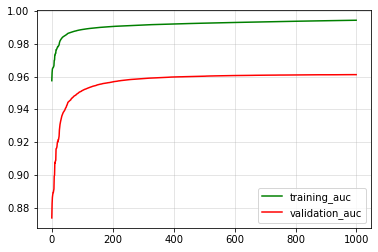

In [51]:
fig,ax=plt.subplots(sharey=True)
sn.lineplot(list(range(len(xgb.evals_result_.get('validation_0').get('auc')))),xgb.evals_result_.get('validation_0').get('auc'),color='green',label='training_auc',ax=ax)
sn.lineplot(list(range(len(xgb.evals_result_.get('validation_1').get('auc')))),xgb.evals_result_.get('validation_1').get('auc'),color='red',label='validation_auc',ax=ax)
plt.grid(alpha=0.4)
plt.legend(loc=0)
plt.show()

In [52]:
with open('xgb.pkl','wb') as f:
    pickle.dump(final_xgb,f)

In [ ]:
from scipy.optimize import fmin

In [ ]:
class Optimize:
  def __init__(self,data1,data2,data3,y):
    self.d1=data1
    self.d2=data2
    self.d3=data3
    self.y=y
    self.coef=0
  def get_score(self,coef):
    data=coef[0]*self.d1+coef[1]*self.d2+coef[2]*self.d3
    score=roc_auc_score(self.y,data)
    return -1.0*score
  def opt(self):
    init_coef=np.random.dirichlet(np.ones(2,))
    self.coef=fmin(self.get_score,init_coef,disp=1)
    return self.coef


In [ ]:
colsample_bytree= 0.8166911250194073
gamma=1.0880194042053906
max_depth= 10
reg_lambda= 497.47428517801467
subsample= 0.9424502628308582

In [ ]:
for i in tqdm(range(5)):
    train=df[df['kfolds']!=i].drop(['kfolds','QuoteNumber'],axis=1).reset_index(drop=True)
    test=df[df['kfolds']==i].drop(['kfolds','QuoteNumber'],axis=1).reset_index(drop=True)
    x_train=train.drop('QuoteConversion_Flag',axis=1).values
    y_train=train['QuoteConversion_Flag'].values
    x_test=test.drop('QuoteConversion_Flag',axis=1).values
    y_test=test['QuoteConversion_Flag'].values
    x_train,y_train=smote.fit_sample(x_train,y_train)
    x_train=scaler.fit_transform(x_train)
    x_test=scaler.transform(x_test)
    xgb.fit(x_train,y_train,verbose=0)
    predictions=xgb.predict_proba(x_test)
    predictions1=predictions[:,1]
    lgb.fit(x_train,y_train,verbose=0)
    predictions=lgb.predict_proba(x_test)
    predictions2=predictions[:,1]
    rfc.fit(x_train,y_train)
    predictions=rfc.predict_proba(x_test)
    predictions3=predictions[:,1]
    weights=Optimize(predictions1,predictions2,predictions3,y_test)
    #score=roc_auc_score(y_test,predictions1)
    print(f"\n\nfor the {i+1}th fold the weights is {weights.opt()}\n\n")
    #print(score)




there is not much increase the metric

In [ ]:
del weights,xgb,lgb

In [ ]:
gc.collect()

# submission

In [ ]:
sub=pd.read_csv('./test.csv')

In [ ]:
sub.head()

In [ ]:
sub['Original_Quote_Date']=pd.to_datetime(sub['Original_Quote_Date'])
sub['weekdays']=sub['Original_Quote_Date'].dt.dayofweek
sub['month']=sub['Original_Quote_Date'].dt.month
sub['month_sin']=sub['month'].apply(lambda x: np.sin(x-1/11))
sub['months_cos']=sub['month'].apply(lambda x: np.cos(x-1/11))
sub['weekdays_sin']=sub['weekdays'].apply(lambda x: np.sin(x/6))
sub['weekdays_cos']=sub['weekdays'].apply(lambda x: np.cos(x/6))
sub.drop(['month','weekdays'],axis=1,inplace=True)
sub['Field6']=sub['Field6'].apply(lambda x: x if x not in ['C','A','D'] else 'field6_others')
sub.drop(['PersonalField7','PropertyField29','Original_Quote_Date','PropertyField6','GeographicField10A',
         ],
        axis=1,inplace=True)

sub['PersonalField84'].fillna(value=-1,inplace=True)
sub['PropertyField3'].fillna(value='N',inplace=True)
sub['PropertyField4'].fillna(value='N',inplace=True)
sub['PropertyField32'].fillna(value='Y',inplace=True)
sub['PropertyField34'].fillna(value='Y',inplace=True)
sub['PropertyField36'].fillna(value='N',inplace=True)
sub['PropertyField38'].fillna(value='N',inplace=True)
drops=pd.DataFrame(sub.isna().sum())
drops[drops[0]!=0].index

In [ ]:
sub['PropertyField37']=sub['PropertyField37'].map({'Y':'Y','N':'N',' ':'N'})

In [ ]:
sub.drop(first_drop,axis=1,inplace=True)
sub.drop(second_drop,axis=1,inplace=True)

In [ ]:
sub['QuoteConversion_Flag']=0

In [ ]:
drops=pd.DataFrame(sub.isna().sum())
drops[drops[0]!=0].index

In [ ]:
sub['PropertyField5'].fillna(value='Y',inplace=True)

In [ ]:
sub['PropertyField30'].fillna(value='Y',inplace=True)

In [ ]:
drops=pd.DataFrame(sub.isna().sum())
drops[drops[0]!=0].index

I found out that there are some new categories in out test.csv. So, I changed from using pd.get_dummies() to ohe hot encoding has I am using tree based alogorithms no need to have (k-1) categories, we can have k category columns for each feature. The main purpose of using onehotencoding instead of simply using get_dummies, In onehot encoding we have option handle_unknown feature which is default set to error which means if we have new category it raises an error, So to handle them I set it to ignore. Now, when I get a new category for that feature it sets all category values to zero. If we use pd.get_dummies then it will create new feature for this category for which our model is not trained and we may not get good results

In [ ]:
sub.head()

In [ ]:
requried_columns=list(sub.columns)

In [ ]:
sub.shape

In [ ]:
for col in tqdm(category_columns):
  transformer=encoding_dict.get(col).get('transformer')
  categories=encoding_dict.get(col).get('categories')
  temp=pd.DataFrame(data=transformer.transform(sub[[col]]),columns=categories)
  sub=sub.join(temp)
  sub.drop(col,axis=1,inplace=True)

In [ ]:
x=sub.drop(['QuoteConversion_Flag','QuoteNumber'],axis=1).values
#x=scaler.transform(x)

In [ ]:
x.shape

In [ ]:
temp=scaler.transform(x[i:i+1,])

In [ ]:
temp.shape

In [ ]:
for i in tqdm(range(x.shape[0])):
    testing=scaler.transform(x[i:i+1,])
    predict=final_xgb.predict(testing)
    predict2=final_lgb.predict(testing)
    print(predict.shape)
    print(predict)
    break
    sub.loc[i,'QuoteConversion_Flag']=final_weights[0]*predict1+final_weights[1]*predict2
    

In [ ]:
cols=list(sub.columns)

In [ ]:
drop_cols=list(i for i in cols if i not in ['QuoteConversion_Flag','QuoteNumber'])

In [ ]:
sub.drop(drop_cols,axis=1,inplace=True)

In [ ]:
sub.head()

In [ ]:
sub.to_csv('submission.csv',index=False)